Sub-Task 1:

Build churn model(s) to try to predict the churn probability of any customer, taking into account all the explanatory variables you have constructed in the feature engineering process.

Sub-Task 2:

Evaluate your model, using a holdout set, and with metrics of your choosing. Be sure to pick a metric that would make sense for this business case.

Sub-Task 3:

Interpret the results and use them to formulate your answers to the client’s hypotheses and questions. You will be asked to form these answers into coherent thoughts and recommendations in the next module.

## 0. Import packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os 
import pandas as pd
import seaborn as sns
import datetime
import pickle

import shap
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb

In [5]:
# Show plots in jupyter notebook
%matplotlibinline

UsageError: Line magic function `%matplotlibinline` not found.


In [6]:
# Set plot style
sns.set(color_codes=True)

In [7]:
# Set maximum number of columns to be displayed
pd.set_option('display.max_columns', 100)

In [8]:
# load JS visualization code to notebook
shap.initjs()

## 0. Load data

In [13]:
train_data = pd.read_pickle("../processed_data/train_data2.pkl")
history_data = pd.read_pickle("../processed_data/history_features.pkl")

In [14]:
train=pd.merge(train_data, history_data, on="id")

In [15]:
pd.DataFrame({"Dataframe columns": train.columns})

,Dataframe columns
0,id
1,cons_12m
2,cons_gas_12m
3,cons_last_month
4,forecast_cons_12m
5,forecast_discount_energy
6,forecast_meter_rent_12m
7,forecast_price_energy_p1
8,forecast_price_energy_p2
9,forecast_price_pow_p1


## 1. Splitting data

In [16]:
y=train["churn"]
X=train.drop(labels= ["id","churn"],axis=1)

In [17]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.25, random_state=18)

## 2. Modelling

In [18]:
model=xgb.XGBClassifier(learning_rate=0.1,max_depth=6,n_estimators=500,n_jobs=-1)
result=model.fit(X_train,y_train)

## 3. Model evaluation

In [20]:
def evaluate(model_, X_test_, y_test_):
    """    Evaluate the accuracy, precision and recall of a model    """
    
    # Get the model predictions
    prediction_test_=model_.predict(X_test_)
    
    # Print the evaluation metrics as pandas dataframe
    results=pd.DataFrame({"Accuracy" : [metrics.accuracy_score(y_test_, prediction_test_)],
                          "Precision" : [metrics.precision_score(y_test_, prediction_test_)],
                          "Recall" : [metrics.recall_score(y_test_, prediction_test_)]})
    
    # For a more detailed report
    #print(metrics.classification_report(y_test_, prediction_test_))
    return results

In [21]:
evaluate(model, X_test, y_test)

,Accuracy,Precision,Recall
0,0.907306,0.769231,0.144578


### ROC curve & AUC

In [22]:
def calculate_roc_auc(model_, X_test_, y_test_):
    """    
    Evaluate the roc-auc score    
    """
    
    # Get the model predictions
    # Note that we are using the prediction for the class 1 -> churn
    prediction_test_=model_.predict_proba(X_test_)[:,1]
    
    # Compute roc-auc
    fpr, tpr, thresholds=metrics.roc_curve(y_test_, prediction_test_)
    
    # Print the evaluation metrics as pandas dataframe
    score=pd.DataFrame({"ROC-AUC" : [metrics.auc(fpr, tpr)]})
    return fpr, tpr, score

In [23]:
def plot_roc_auc(fpr,tpr):
    """    
    Plot the Receiver Operating Characteristic from a list    
    of true positive rates and false positive rates.    
    """
    
    # Initialize plot
    f, ax=plt.subplots(figsize=(14,8))
    
    # Plot ROC
    roc_auc=metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, lw=2, alpha=0.3,
            label="AUC = %0.2f"% (roc_auc))
    
    # Plot the random line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
             label="Random", alpha=.8)
    
    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel("False Positive Rate (FPR)")
    ax.set_ylabel("True Positive Rate (TPR)")
    ax.set_title("ROC-AUC")
    ax.legend(loc="lower right")
    plt.show()

In [24]:
fpr, tpr, auc_score=calculate_roc_auc(model, X_test, y_test)

In [25]:
auc_score

,ROC-AUC
0,0.684637


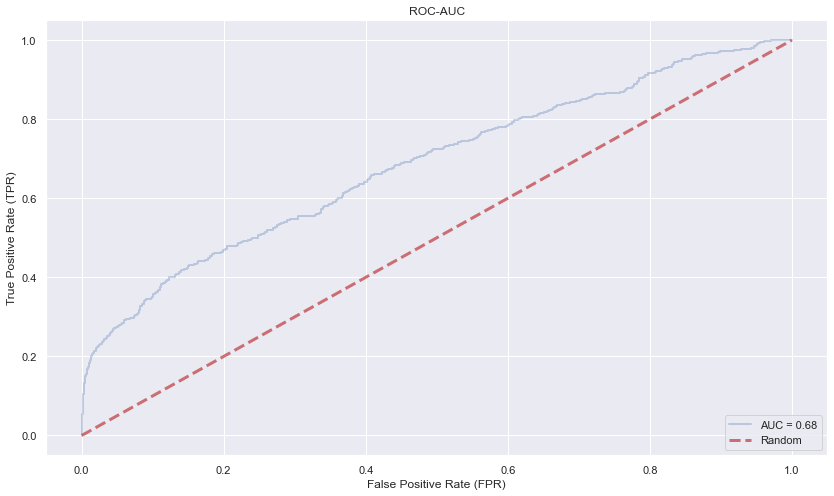

In [26]:
plot_roc_auc(fpr, tpr)
plt.show()

### Stratified K-fold validation

In [28]:
def plot_roc_curve(fprs, tprs):
    """    
    Plot the Receiver Operating Characteristic from a list    
    of true positive rates and false positive rates.    
    """
    
    # Initialize useful lists + the plot axes.
    tprs_interp= []
    aucs= []
    mean_fpr=np.linspace(0, 1, 100)
    f, ax=plt.subplots(figsize=(18,10))
    
    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] =0.0
        roc_auc=metrics.auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=2, alpha=0.3,
                label="ROC fold %d (AUC = %0.2f)"% (i, roc_auc))
    
    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r',
             label="Random", alpha=.8)
    
    # Plot the mean ROC.
    mean_tpr=np.mean(tprs_interp, axis=0)
    mean_tpr[-1] =1.0
    mean_auc=metrics.auc(mean_fpr, mean_tpr)
    std_auc=np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)"% (mean_auc, std_auc),
            lw=4, alpha=.8)
    
    # Plot the standard deviation around the mean ROC.
    std_tpr=np.std(tprs_interp, axis=0)
    tprs_upper=np.minimum(mean_tpr+std_tpr, 1)
    tprs_lower=np.maximum(mean_tpr-std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color="grey", alpha=.2,
                    label=r"$\pm$ 1 std. dev.")
    
   # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel("False Positive Rate (FPR)")
    ax.set_ylabel("True Positive Rate (TPR)")
    ax.set_title("ROC-AUC")
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax) 
    
    
    

In [29]:
def compute_roc_auc(model_, index):
    y_predict=model_.predict_proba(X.iloc[index])[:,1]
    fpr, tpr, thresholds=metrics.roc_curve(y.iloc[index], y_predict)
    auc_score=metrics.auc(fpr, tpr)
    return fpr, tpr, auc_score

In [30]:
cv=StratifiedKFold(n_splits=5, random_state=13, shuffle=True)
fprs, tprs, scores= [], [], []

In [31]:
for (train, test), i in zip(cv.split(X, y), range(5)):
    model.fit(X.iloc[train], y.iloc[train])
    _, _, auc_score_train=compute_roc_auc(model, train)
    fpr, tpr, auc_score=compute_roc_auc(model, test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

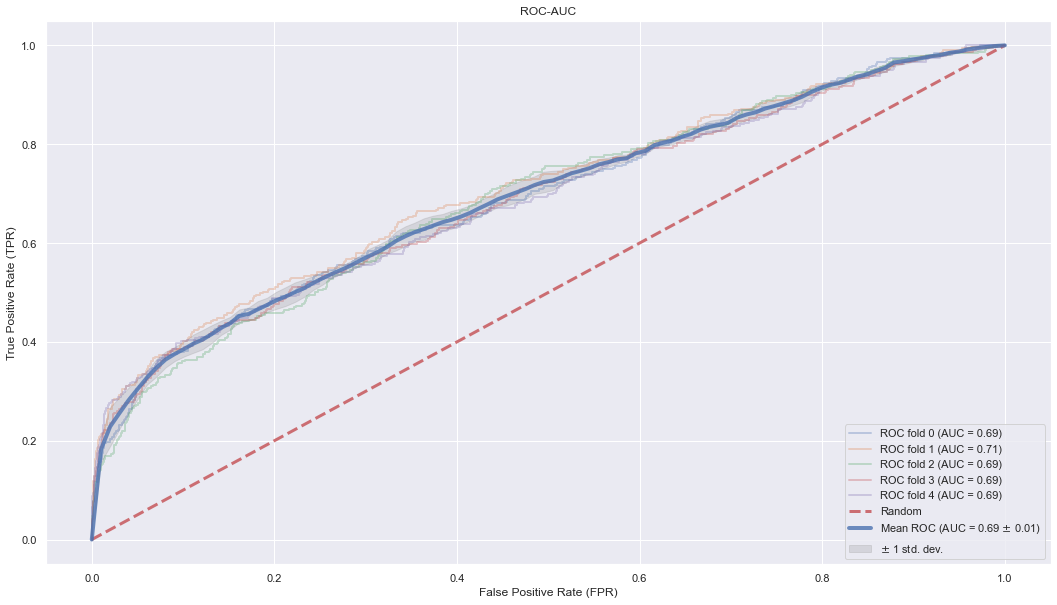

In [32]:
plot_roc_curve(fprs, tprs)
plt.show()

## 4. Model finetuning


#### Random Search Cross Validation


In [33]:
from sklearn.model_selection import RandomizedSearchCV

In [35]:
# Create the random grid
params= {'min_child_weight': [i for i in np.arange(1,15,1)],
         'gamma': [i for i in np.arange(0,6,0.5)],
         'subsample': [i for i in np.arange(0,1.1,0.1)],
         'colsample_bytree':  [i for i in np.arange(0,1.1,0.1)],
         'max_depth': [i for i in np.arange(1,15,1)],
         'scale_pos_weight':[i for i in np.arange(1,15,1)],
         'learning_rate': [i for i in np.arange(0,0.15,0.01)],
         'n_estimators' : [i for i in np.arange(0,2000,100)]        
        }

In [36]:
# Create model
xg=xgb.XGBClassifier(objective='binary:logistic',
                     silent=True, nthread=1)

In [37]:
# Random search of parameters, using 5
xg_random=RandomizedSearchCV(xg, param_distributions=params,
                             n_iter=1, scoring="roc_auc",
                             n_jobs=4, cv=5, verbose=3, random_state=1001)

# Fit the random search model
xg_random.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    2.7s remaining:    4.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    3.3s finished


RandomizedSearchCV(cv=5, estimator=XGBClassifier(nthread=1, silent=True),
                   n_iter=1, n_jobs=4,
                   param_distributions={'colsample_bytree': [0.0, 0.1, 0.2,
                                                             0.30000000000000004,
                                                             0.4, 0.5,
                                                             0.6000000000000001,
                                                             0.7000000000000001,
                                                             0.8, 0.9, 1.0],
                                        'gamma': [0.0, 0.5, 1.0, 1.5, 2.0, 2.5,
                                                  3.0, 3.5, 4.0, 4.5, 5.0,
                                                  5.5],
                                        'learning_rate': [0.0, 0.01, 0.02, 0.03,
                                                          0.04, 0.05, 0.06,
                                                   

In [38]:
best_random=xg_random.best_params_
best_random= {'subsample': 0.8,
              'scale_pos_weight': 1,
              'n_estimators': 1100,
              'min_child_weight': 1,
              'max_depth': 12,
              'learning_rate': 0.01,
              'gamma': 4.0,
              'colsample_bytree': 0.60}

In [39]:
# Create a model with the parameters found
model_random=xgb.XGBClassifier(objective='binary:logistic',
                               silent=True, nthread=1, **best_random)
fprs, tprs, scores= [], [], []

In [40]:
for (train, test), i in zip(cv.split(X, y), range(5)):
    model_random.fit(X.iloc[train], y.iloc[train])
    _, _, auc_score_train=compute_roc_auc(model_random, train)
    fpr, tpr, auc_score=compute_roc_auc(model_random, test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

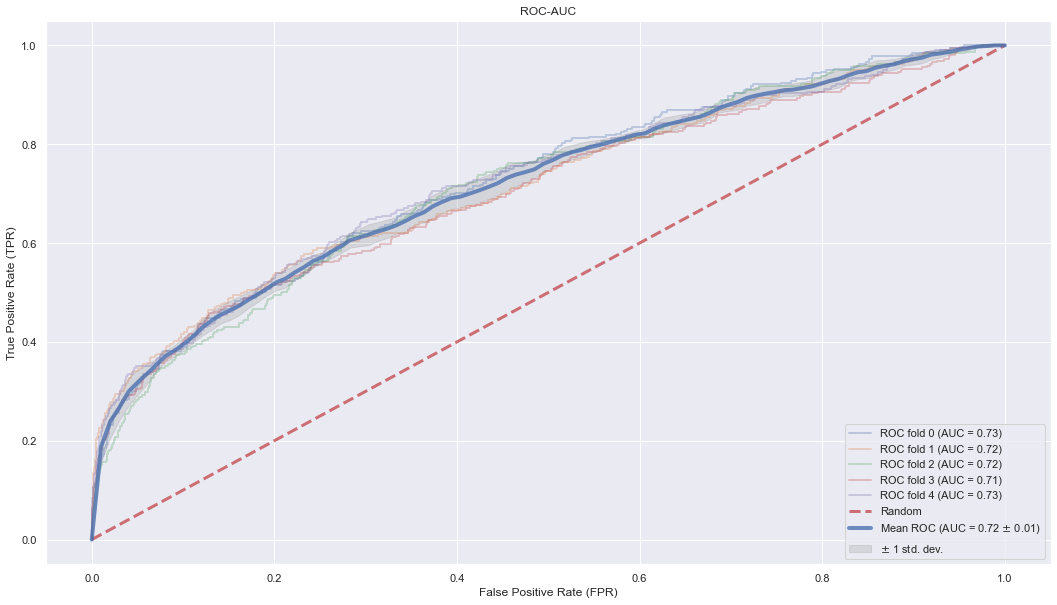

In [41]:
plot_roc_curve(fprs, tprs)
plt.show()

#### Grid search with cross validation (calculating over weekend, then make smaller)

In [42]:
from sklearn.model_selection import GridSearchCV

In [43]:
# Create the parameter grid based on the results of random search 
param_grid=   {'subsample': [0.7],
               'scale_pos_weight': [1],
               'n_estimators': [1100],
               'min_child_weight': [1],
               'max_depth': [12, 13, 14],
               'learning_rate': [0.005, 0.01],
               'gamma': [4.0],
               'colsample_bytree': [0.6]}

In [44]:
# Create model
xg=xgb.XGBClassifier(objective='binary:logistic',
                     silent=True, nthread=1)

In [45]:
# Instantiate the grid search model
grid_search=GridSearchCV(estimator=xg, param_grid=param_grid, 
                         cv=5, n_jobs=-1, verbose=2, scoring="roc_auc")

In [46]:
# Fit the grid search to the data
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.9min finished


GridSearchCV(cv=5, estimator=XGBClassifier(nthread=1, silent=True), n_jobs=-1,
             param_grid={'colsample_bytree': [0.6], 'gamma': [4.0],
                         'learning_rate': [0.005, 0.01],
                         'max_depth': [12, 13, 14], 'min_child_weight': [1],
                         'n_estimators': [1100], 'scale_pos_weight': [1],
                         'subsample': [0.7]},
             scoring='roc_auc', verbose=2)

In [47]:
best_grid=grid_search.best_params_
best_grid

{'colsample_bytree': 0.6,
 'gamma': 4.0,
 'learning_rate': 0.005,
 'max_depth': 12,
 'min_child_weight': 1,
 'n_estimators': 1100,
 'scale_pos_weight': 1,
 'subsample': 0.7}

In [48]:
# Create a model with the parameters found
model_grid=xgb.XGBClassifier(objective='binary:logistic',
                             silent=True, nthread=1, **best_grid)
fprs, tprs, scores= [], [], []

In [49]:
for (train, test), i in zip(cv.split(X, y), range(5)):
    model_grid.fit(X.iloc[train], y.iloc[train])
    _, _, auc_score_train=compute_roc_auc(model_grid, train)
    fpr, tpr, auc_score=compute_roc_auc(model_grid, test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

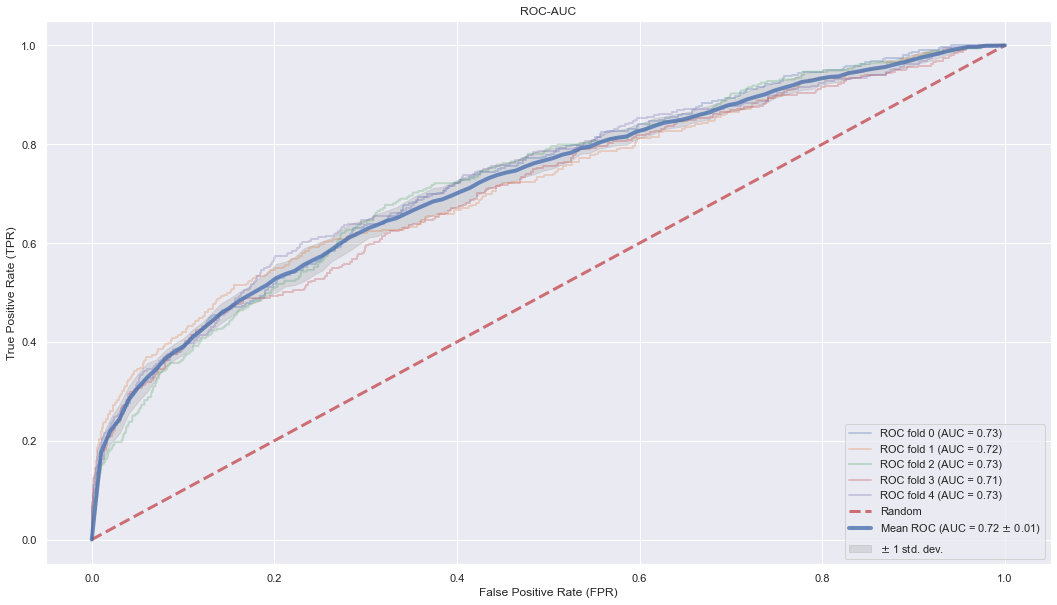

In [50]:
plot_roc_curve(fprs, tprs)
plt.show()

## 5. Understanding the model

#### Feature importance

One simple way of boserving the feature importance is through counting the number of times each feature is split on across all boosting rounds (trees)in the model, and then visualizing the result as a bar graph, with the features ordered according to how many times they appear

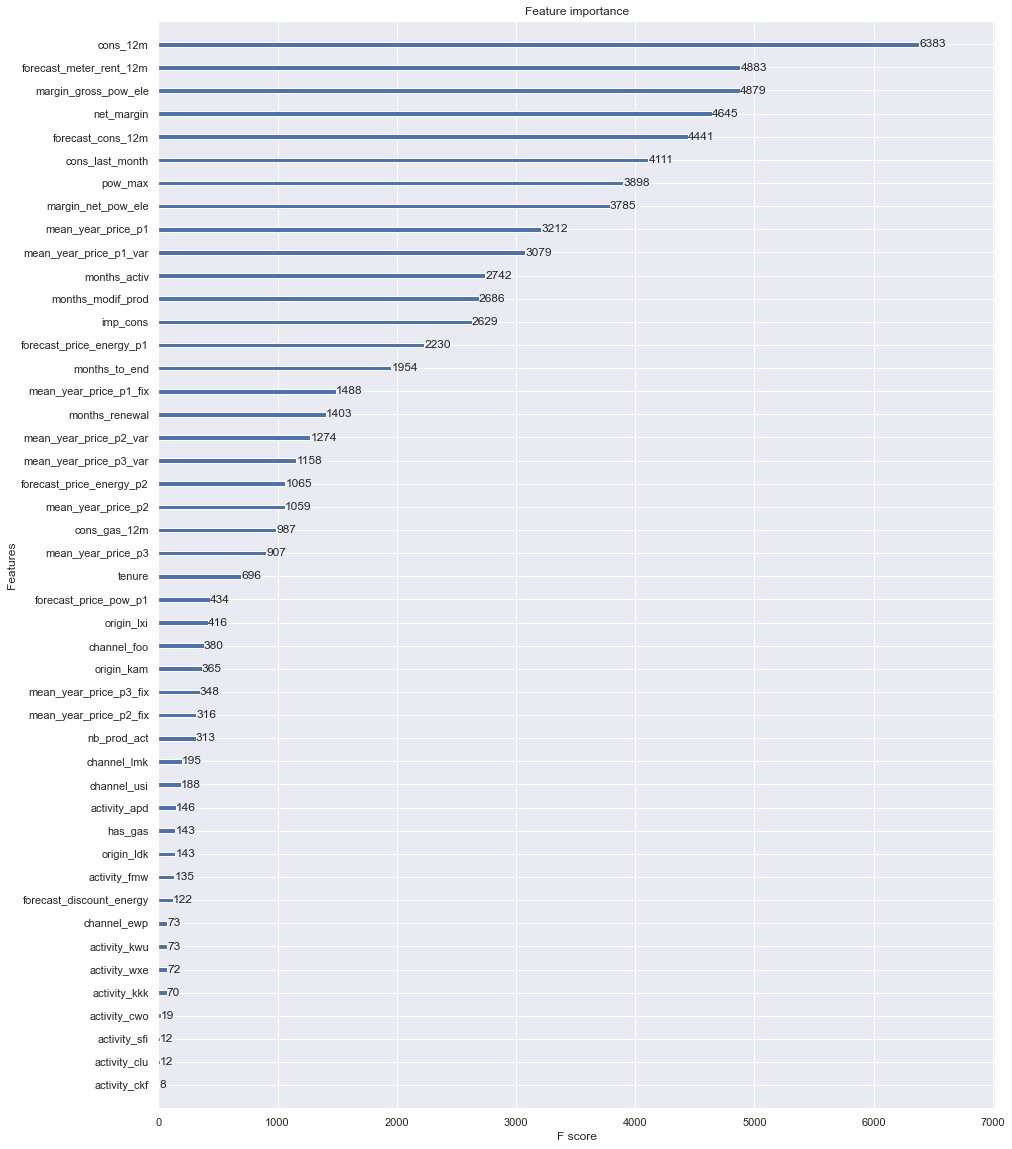

In [51]:
fig, ax=plt.subplots(figsize=(15,20))
xgb.plot_importance(model_grid, ax=ax)

#### Partial dependence plot

In [53]:
from sklearn.inspection import plot_partial_dependence


Because currently there is a bug that does not allow us to use our trained model with pandas dataframes, we will create a replica and train it usingnumpy arrays

In [54]:
# Create a model with the parameters found
model_grid_v2=xgb.XGBClassifier(objective='binary:logistic',
                                silent=True, nthread=1, **best_grid)
model_grid_v2.fit(X_train.values,y_train.values)

XGBClassifier(colsample_bytree=0.6, gamma=4.0, learning_rate=0.005,
              max_depth=12, n_estimators=1100, nthread=1, silent=True,
              subsample=0.7)

The fig parameter is deprecated in version 0.22 and will be removed in version 0.24


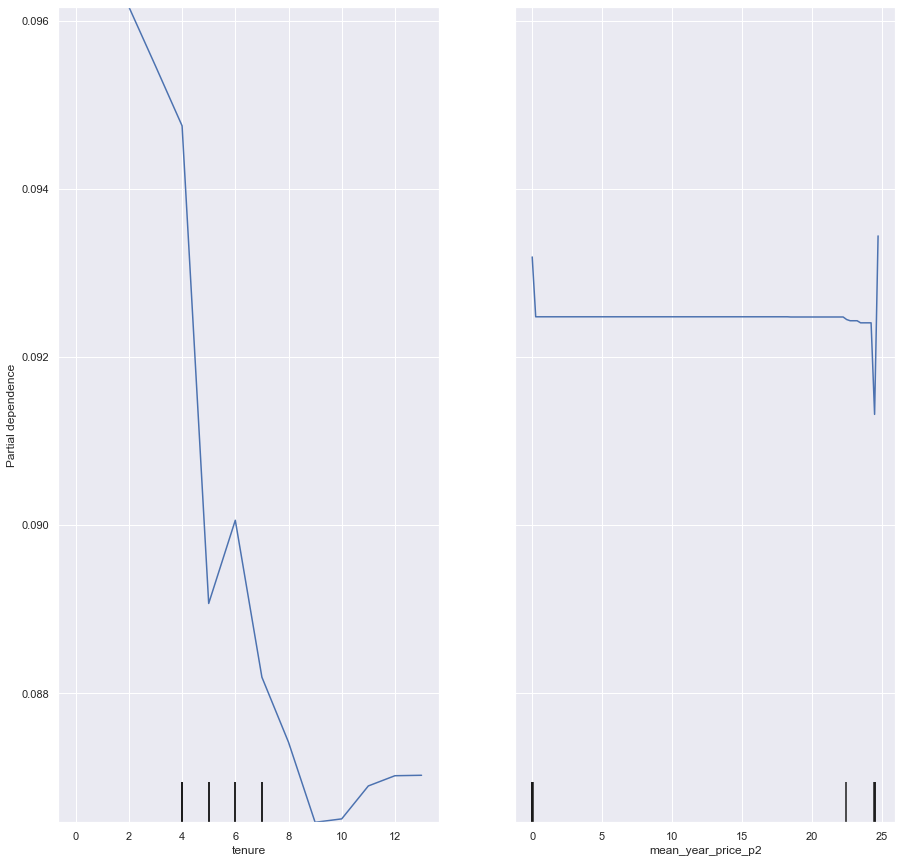

In [55]:
fig=plt.figure(figsize=(15,15))
plot_partial_dependence(model_grid_v2, X_test.values, 
                        features=[16, 49], 
                        feature_names=X_test.columns.tolist(),
                        fig=fig)

Comparing the PDP plots with respect to our previous models, we can see how they are slightly different.

tenure

The overall trend is unchaged as compared to our previous models. We can see the trend spikes at slighly different times of the tenure (6y) but thenit goes down again and bottoms around 10 years. Then, it starts recovering a bit.

mean_year_price_p2

In our previous models, we saw a sort of "stairshape", in this case we see the pdp is almost flat with some spikes on the extreme values, which hintsus that the variable mean_year_price_p2 is not very relevant in this model.

#### SHAP - Feature importance

In [56]:
explainer=shap.TreeExplainer(model_grid)
shap_values=explainer.shap_values(X_test)

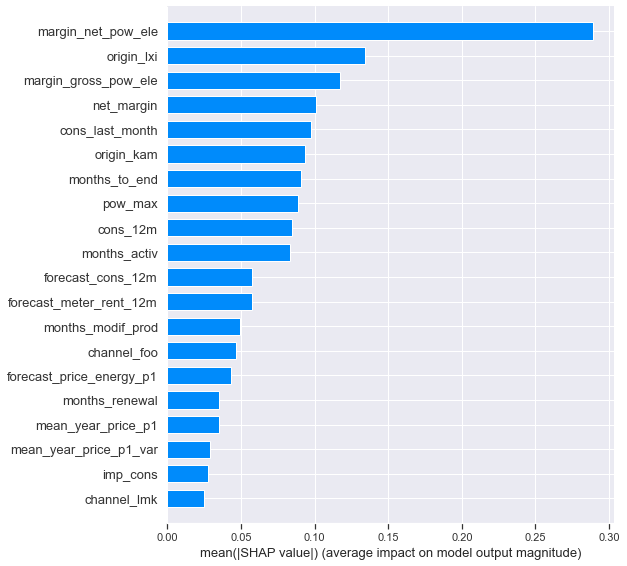

In [57]:
# Feature importance for class 1 - churn
shap.summary_plot(shap_values, X_test, plot_type='bar')

As expected the margin_net_pow_ele is the most important feature by far. It is interesting to compare how much important the top featurebecomes in contrast with the other models we created Random forest and Logistic Regression

#### SHAP - Partial dependence plot

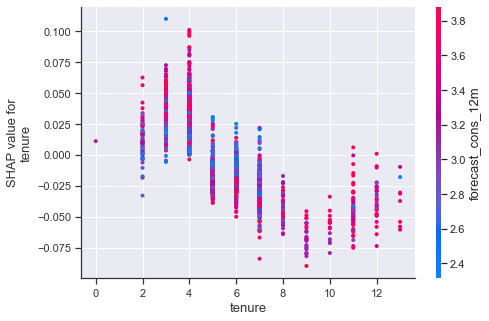

In [58]:
shap.dependence_plot("tenure", shap_values, X_test)#, interaction_index="origin_lxi")

In this case we see a much clearer pattern, in which the longer the tenure the less likely the company is, sort of decreasing linearly until it bottomsaround 9y of tenure. From year 10 of tenure, the churn increases again.

#### SHAP - Single prediction

In [59]:
shap.force_plot(explainer.expected_value, shap_values[4023], X_test.iloc[4023,:], link="logit")

We can see in here how the different features interacted to result in the above prediction. In this case, the high values of the margin_net_pow_eleand margin_gross_pow_ele pushed the likely of churning way above the baseline.